## Named Entity Relationship(NER) 
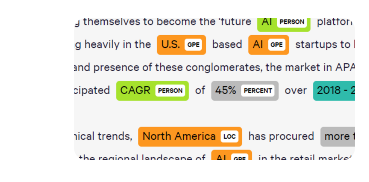

Itis a common task that involves identifying and categorizing  named entities. The project include on simpler task of sentence likelihood prediction, that involves in determining the probability of a given sentence being valid based on a Hidden Markov Model(HMM) and Part-Of-Speech(POS) Tagging. I have also implemented the Viterbi algorithm to determine the best probable path and compare it with the hmmlearn implementation. Additionally, formulated an HMM and completed the forward and backward function in the Baum-Welch algorithm to improve the HMM model. 



In [1]:
!pip install hmmlearn==0.2.6

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.2/155.2 kB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for hmmlearn: filename=hmmlearn-0.2.6-cp310-cp310-linux_x86_64.whl size=157362 sha256=d216e88f66a85b42746f8f7bf5617765f130f180673347b9877e2e0bf6de0255
  Stored in directory: /root/.cache/pip/wheels/9a/9c/0d/ad94b4e1c2388b051cf78a0207f033b08b2c7d15ede782b431
Successfully built hmmlearn
  Attempting uninstall: hmmlearn
    Found existing installation: hmmlearn 0.3.0
    Uninstalling hmmlearn-0.3.0:
      Successfully uninstalled hmmlearn-0.3.0


In [2]:
# !pip install --force-reinstall hmmlearn == 0.2.6
import hmmlearn
from hmmlearn import hmm

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### Check that the hmmlearn installed is version 0.2.6

In [3]:
!pip show hmmlearn  # check that the version installed is 0.2.6

Name: hmmlearn
Version: 0.2.6
Summary: Hidden Markov Models in Python with scikit-learn like API
Home-page: https://github.com/hmmlearn/hmmlearn
Author: 
Author-email: 
License: new BSD
Location: /opt/conda/lib/python3.10/site-packages
Requires: numpy, scikit-learn, scipy
Required-by: 


### Imports

In [4]:
import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
from tqdm import tqdm
from matplotlib import pyplot as plt  # show graph
import random

#some other libraries
import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

from typing import List

from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, \
    f1_score, roc_auc_score

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## In this notebook we will look at the NER dataset and use it to understand HMM.

### Data Description:
#### sentence: this column donates to which sentence the word belongs
#### Word: the word in the sentence
#### POS: Associated POS tag for the word

## Load the data



In [ ]:
data = pd.read_csv("data/NER dataset.csv", encoding='latin1')

The dataset contains a total of 47960 sentences, with 1,048,575 words. The entities includes 9 named entity types including person names, locations, organizations, dates, times, percentages and others.



In [6]:
data = data.fillna(method="ffill")
data = data.rename(columns={'Sentence #': 'sentence'})
data.head(5)

,sentence,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O


# Data pre-processing
If you want to do some pre-processing (lowercase any words, remove stop words, replace numbers/names by a unique NUM/NAME token, etc.) you can do it here in the pipeline.

Note : you could create a new dataset `data_pre_precessed = pre_process(data)` to keep both version and compare the effect of you pre-processing.

In [7]:
def pre_processing(text_column):
    # lowercase all text in the column
    text_column = text_column.str.lower()

    # replacing numbers with NUM token
    text_column = text_column.str.replace(r'\d+', 'NUM')

    # removing stopwords
    stop_words = set(stopwords.words('english'))
    text_column = text_column.apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))

    return text_column


The pre-processing step is performed to clean and transform the data in a way that is more suitable for further analysis. The pre-processing functions performed includes, converting all the words in the 'Word' column to lowercase and this is done to standardize the capitalization of the words and ensure that they are all in the same case. Then replaced all the numeric values in the 'Word' column with the token 'NUM'. This is done to avoid overfitting of the model to specific numerical values that may not be relevant to the task. Then removed the stop words, which are common words that don't convey any significant meaning in the context of the text. The number of unique POS tags and unique words in the original dataset was 42 and 29764 respectively. After pre-processing and removing empty/null rows, the number of unique words is reduced to 24031.

First let's collect the unique words and the unique POS tags in the dataset, we will use this to construct the HMM later

In [8]:
data_pre_precessed = pre_processing(data.Word)

/tmp/ipykernel_35/3849771148.py:6: FutureWarning: The default value of regex will change from True to False in a future version.
  text_column = text_column.str.replace(r'\d+', 'NUM')


In [9]:
data_pre_precessed.head(20)

0         thousands
1                  
2     demonstrators
3                  
4           marched
5                  
6            london
7                  
8           protest
9                  
10              war
11                 
12             iraq
13                 
14           demand
15                 
16       withdrawal
17                 
18          british
19           troops
Name: Word, dtype: object

In [10]:
#creating new dataframe with preprocessed word as a column
data_processed = data
data_processed['Word'] = data_pre_precessed

#removing the rows where word is empty
data_processed = data_processed[(data_processed['Word'] != '') | (data_processed['Word'].isna())]

In [11]:
data_processed.head(20)

,sentence,Word,POS,Tag
0,Sentence: 1,thousands,NNS,O
2,Sentence: 1,demonstrators,NNS,O
4,Sentence: 1,marched,VBN,O
6,Sentence: 1,london,NNP,B-geo
8,Sentence: 1,protest,VB,O
10,Sentence: 1,war,NN,O
12,Sentence: 1,iraq,NNP,B-geo
14,Sentence: 1,demand,VB,O
16,Sentence: 1,withdrawal,NN,O
18,Sentence: 1,british,JJ,B-gpe


In [12]:
tags = list(set(data.POS.values))  # Unique POS tags in the dataset
words = list(set(data.Word.values))  # Unique words in the dataset
len(tags), len(words)

(42, 29764)

In [13]:
words1 = list(set(data_processed.Word.values))  # Unique words in the dataset
len(words1)

29763

### We have 42 different tags and 29,764 different words, so the HMM that we construct will have the following properties
- The hidden states of the this HMM will correspond to the POS tags, so we will have 42 hidden states.
- The Observations for this HMM will correspond to the sentences and their words.

#### Before constructing the HMM, we will split the data into train and test.

In [14]:
y = data.POS
X = data.drop('POS', axis=1)

gs = GroupShuffleSplit(n_splits=2, test_size=.33, random_state=42)
train_ix, test_ix = next(gs.split(X, y, groups=data['sentence']))

data_train = data.loc[train_ix]
data_test = data.loc[test_ix]

In [15]:
data_train.head(5)

,sentence,Word,POS,Tag
24,Sentence: 2,families,NNS,O
25,Sentence: 2,,IN,O
26,Sentence: 2,soldiers,NNS,O
27,Sentence: 2,killed,VBN,O
28,Sentence: 2,,IN,O


In [16]:
data_test.head(5)

,sentence,Word,POS,Tag
0,Sentence: 1,thousands,NNS,O
1,Sentence: 1,,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,,VBP,O
4,Sentence: 1,marched,VBN,O


In [17]:
#using preprocessed data 

y1 = data_processed.POS
X1 = data_processed.drop('POS', axis=1)
data_processed.reset_index(drop=True, inplace=True)
gs = GroupShuffleSplit(n_splits=2, test_size=.33, random_state=42)
train_ix1, test_ix1 = next(gs.split(X1, y1, groups=data_processed['sentence']))

data_train1 = data_processed.loc[train_ix1]
data_test1 = data_processed.loc[test_ix1]

In [18]:
data_train1.head()

,sentence,Word,POS,Tag
13,Sentence: 2,families,NNS,O
14,Sentence: 2,soldiers,NNS,O
15,Sentence: 2,killed,VBN,O
16,Sentence: 2,conflict,NN,O
17,Sentence: 2,joined,VBD,O


In [19]:
data_test1.head()

,sentence,Word,POS,Tag
0,Sentence: 1,thousands,NNS,O
1,Sentence: 1,demonstrators,NNS,O
2,Sentence: 1,marched,VBN,O
3,Sentence: 1,london,NNP,B-geo
4,Sentence: 1,protest,VB,O


Now lets encode the POS and Words to be used to generate the HMM.

In [20]:
dfupdate = data_train.sample(frac=.15, replace=False, random_state=42)
dfupdate.Word = 'UNKNOWN'
data_train.update(dfupdate)
words = list(set(data_train.Word.values))
# Convert words and tags into numbers
word2id = {w: i for i, w in enumerate(words)}
tag2id = {t: i for i, t in enumerate(tags)}
id2tag = {i: t for i, t in enumerate(tags)}
len(tags), len(words)

(42, 23607)

In your theory classes you might have seen that the Hidden Markov Models can be learned by using the Baum-Welch algorithm by just using the observations.
Although we can learn the Hidden States (POS tags) using Baum-Welch algorithm,We cannot map them back the states (words) to the POS tag. So for this exercise we will skip using the BW algorithm and directly create the HMM.

For creating the HMM we should build the following three parameters. 
- `startprob_`
- `transmat_`
- `emissionprob_`

To construct the above mentioned paramters let's first create some useful matrices that will assist us in creating the above three parameters

In [21]:
count_tags = dict(data_train.POS.value_counts())  # Total number of POS tags in the dataset
# Now let's create the tags to words count
count_tags_to_words = data_train.groupby(['POS']).apply(
    lambda grp: grp.groupby('Word')['POS'].count().to_dict()).to_dict()
# We shall also collect the counts for the first tags in the sentence
count_init_tags = dict(data_train.groupby('sentence').first().POS.value_counts())

# Create a mapping that stores the frequency of transitions in tags to it's next tags
count_tags_to_next_tags = np.zeros((len(tags), len(tags)), dtype=int)
sentences = list(data_train.sentence)
pos = list(data_train.POS)
for i in tqdm(range(len(sentences)), position=0, leave=True):
    if (i > 0) and (sentences[i] == sentences[i - 1]):
        prevtagid = tag2id[pos[i - 1]]
        nexttagid = tag2id[pos[i]]
        count_tags_to_next_tags[prevtagid][nexttagid] += 1

100%|██████████| 702936/702936 [00:00<00:00, 1025546.52it/s]


Now Let's build the parameter matrices 

In [22]:
startprob = np.zeros((len(tags),))
transmat = np.zeros((len(tags), len(tags)))
emissionprob = np.zeros((len(tags), len(words)))
num_sentences = sum(count_init_tags.values())
sum_tags_to_next_tags = np.sum(count_tags_to_next_tags, axis=1)
for tag, tagid in tqdm(tag2id.items(), position=0, leave=True):
    floatCountTag = float(count_tags.get(tag, 0))
    startprob[tagid] = count_init_tags.get(tag, 0) / num_sentences
    for word, wordid in word2id.items():
        emissionprob[tagid][wordid] = count_tags_to_words.get(tag, {}).get(word, 0) / floatCountTag
    for tag2, tagid2 in tag2id.items():
        transmat[tagid][tagid2] = count_tags_to_next_tags[tagid][tagid2] / sum_tags_to_next_tags[tagid]

100%|██████████| 42/42 [00:00<00:00, 82.03it/s]


## Task 1: Similar to how we built the hidden state transition probability matrix as shown above, you will built the transition probability between the words. With this matrix write a function that can calculate the log likelihood given a sentence.

In [23]:
#to create word transition matrix

#first step is to count the number of times each word appears in the dataset
count_words = {}
for word in data_train.Word.values:
    count_words[word] = count_words.get(word, 0) + 1

# then count the number of times a word appears after another word
count_word_transitions = {}
for sentence in data_train.groupby('sentence'):
    words = sentence[1]['Word'].values
    for i in range(len(words) - 1):
        w1, w2 = words[i], words[i+1]
        if w1 not in count_word_transitions:
            count_word_transitions[w1] = {}
        count_word_transitions[w1][w2] = count_word_transitions[w1].get(w2, 0) + 1

# convert the counts to probabilities
word_transition_matrix = np.zeros((len(word2id)+1, len(word2id)+1))
sum_words_to_next_words = np.sum([count_word_transitions[w1][w2] for w1 in count_word_transitions for w2 in count_word_transitions[w1]])
for w1, w1id in word2id.items():
    for w2, w2id in word2id.items():
        word_transition_matrix[w1id][w2id] = count_word_transitions.get(w1, {}).get(w2, 0) / sum_words_to_next_words
print(word_transition_matrix.shape)

(23608, 23608)


In [24]:
def calculate_log_likelihood(sentence: List[str], word_transition_matrix) -> float:
    """
    Given a sentence and word_transition_matrix, returns the log-likelihood of the sentence.
    """
    # converting the sentence to a list of word IDs
    sentence_ids = [word2id.get(w, word2id['UNKNOWN']) for w in sentence]

    # calculating the log-likelihood using the word transition matrix
    log_likelihood = np.log(word_transition_matrix[sentence_ids[0]][sentence_ids[1]])
    for i in range(1, len(sentence_ids) - 1):
        log_likelihood += np.log(word_transition_matrix[sentence_ids[i]][sentence_ids[i+1]] + 1e-10)
    return log_likelihood



In [25]:
calculate_log_likelihood(["This", "is", "a", "test", "sentence"], word_transition_matrix)

-41.259970813020175

In this task, a word transition probability matrix is built and a function that can calculate the log likelihood given a sentence. The transition probability matrix was created by first counting the number of times each word appeared in the training dataset and then counting the number of times a word appeared after another word. These counts were then converted to probabilities to create the transition probability matrix.

Then wrote a function to calculate the log-likelihood of a given sentence using the word transition probabilities. The sentence was first converted into a list of word IDs, and then the log-likelihood was calculated using the word transition probabilities. 

#### Now we will continue to constructing the HMM.

We will use the hmmlearn implementation to initialize the HMM Model

In [26]:
model = hmm.MultinomialHMM(n_components=len(tags), algorithm='viterbi', random_state=42)
model.startprob_ = startprob
model.transmat_ = transmat
model.emissionprob_ = emissionprob

#### Before using the HMM to predict the POS tags, we have to fix the training set as some of the words and tags in the test data might not appear in the training data so we collect this data to use it later.

In [27]:
data_test.loc[~data_test['Word'].isin(words), 'Word'] = 'UNKNOWN'
word_test = list(data_test.Word)
samples = []
for i, val in enumerate(word_test):
    samples.append([word2id[val]])

# TODO use panda solution
lengths = []
count = 0
sentences = list(data_test.sentence)
for i in tqdm(range(len(sentences)), position=0, leave=True):
    if (i > 0) and (sentences[i] == sentences[i - 1]):
        count += 1
    elif i > 0:
        lengths.append(count)
        count = 1
    else:
        count = 1

100%|██████████| 345639/345639 [00:00<00:00, 2320709.99it/s]


Now that we have the HMM ready lets predict the best path from them.

In [28]:
pos_predict = model.predict(samples, lengths)
pos_predict

array([33, 15,  6, ...,  3, 35, 18], dtype=int32)

The hmmlearn predict function will give the best probable path for the given sentence using the Viterbi algorithm.

## Task 2: Using the model parameters (startprob_, transmat_, emissionprob_) write the viterbi algorithm from scratch to calculate the best probable path and compare it with the hmmlearn implementation.

Now before using these matrices 

viterbi algorithm to find the best probable path using the model parameters startprob, transmat, emissionprob. The algorithm takes in the initial probabilities, transition probabilities, emission probabilities and a list of obeservations and returns an array of the indices of the best hidden states.

In [29]:

def viterbi(pi: np.array, a: np.array, b: np.array, obs: List) -> np.array:
    """
     Write the viterbi algorithm from scratch to find the best probable path
     attr:
       pi: initial probabilities
       a: transition probabilities
       b: emission probabilities
       obs: list of observations
     return:
       array of the indices of the best hidden states
    """
    # state space cardinality
    K = a.shape[0]

    # observation sequence length
    T = len(obs)

    # initializing the tracking tables from first observation
    delta = np.zeros((T, K))
    psi = np.zeros((T, K))
    delta[0] = pi * b[:, obs[0]]

    # iterating throught the observations updating the tracking tables
    for t in range(1, T):
        for j in range(K):
            delta[t, j] = np.max(delta[t-1] * a[:, j] * b[j, obs[t]])
            psi[t, j] = np.argmax(delta[t-1] * a[:, j])

    # build the output, optimal model trajectory
    x = np.zeros(T, dtype=int)
    x[T-1] = np.argmax(delta[T-1])
    for t in range(T-2, -1, -1):
        x[t] = psi[t+1, x[t+1]]

    return x

### Task 3: Let's try to form our own HMM
In this task you will try to formulate your own HMM. Image a toy example that you think that closely relates to a Hidden Markov Model.

Steps:
 1. Define your hidden states
 2. Define your observable states
 3. Randomly generate your observations

Below is an example to demonstrate:

-In this toy HMM example, we have two hidden states 'healthy' and 'sick' these states relate to the state of a pet. In this example we cannot exactly know the situation of the pet if it is 'healthy' or 'sick'

-The observable states in this formulation is the what our pet is doing, whether it is sleeping, eating or pooping. We ideally want to determine if the pet is sick or not using these observable states


```python
hidden_states = ['healthy', 'sick']
observable_states = ['sleeping', 'eating', 'pooping']
observations = []
for i in range(100):
  observations.append(random.choice(observable_states))
```

In [30]:
import random

hidden_states = ['Sunny', 'Cloudy', 'Rainy']
observable_states = ['Hot', 'Mild', 'Cold', 'Windy', 'Foggy']
observations =  []

for i in range(40):
  obs_index = random.randint(0, len(observable_states)-1) # random index corresponding to the observable state
  observations.append(obs_index) # then adding the index to the observations list

In [31]:
hidden_state_sequence = viterbi(startprob, transmat, emissionprob, observations)

print("Observations:", observations)
print("Viterbi sequence:", hidden_state_sequence)

Observations: [0, 3, 2, 3, 4, 1, 2, 0, 4, 1, 2, 1, 2, 4, 4, 4, 3, 0, 2, 2, 4, 4, 3, 4, 3, 2, 1, 0, 3, 1, 3, 0, 0, 2, 4, 4, 1, 1, 0, 2]
Viterbi sequence: [30 13  8 13 19  6  8 39 19  6  8  6  8 19 19 19 13 32  8  8 19 19 13 19
 13  8  6 30 13  6 13 32 30  8 19 19  6  6 30  8]


Even tough we have generated the data randomly, for the learning purposes, let's try to learn an HMM from this data. For this we have to construct the Baum-Welch algorithm from scratch. Below is the skeleton of the Baum-Welch learning algorithm.

## TASK 4: Complete the forward and backward probs functions in the Baum-Welch algorithm and try it with your formulated HMM.

In [32]:
import numpy as np


def baum_welch(observations, observations_vocab, n_hidden_states):
    """
    Baum-Welch algorithm for estimating the HMM parameters
    :param observations: observations
    :param observations_vocab: observations vocabulary
    :param n_hidden_states: number of hidden states to estimate
    :return: a, b (transition matrix and emission matrix)
    """

    def forward_probs(observations, observations_vocab, n_hidden_states, a_, b_) -> np.array:
        """
        forward pass to calculate alpha
        :param observations: observations
        :param observations_vocab: observation vocabulary
        :param n_hidden_states: number of hidden states
        :param a_: estimated alpha
        :param b_: estimated beta
        :return: refined alpha_
        """
        a_start = 1 / n_hidden_states
        alpha_ = np.zeros((n_hidden_states, len(observations)), dtype=float)
        alpha_[:, 0] = a_start
        for t in range(1, len(observations)):
          for j in range(n_hidden_states):
            calc = observations_vocab == observations[t]
            for i in range(n_hidden_states):
              alpha_[j, t] = sum(alpha_[i, t-1]*a_[i,j] * b_[j, np.where(calc)[0][0]] for i in range(n_hidden_states))

        return alpha_

    def backward_probs(observations, observations_vocab, n_hidden_states, a_, b_) -> np.array:
        """
        backward pass to calculate alpha
        :param observations: observations
        :param observations_vocab: observation vocabulary
        :param n_hidden_states: number of hidden states
        :param a_: estimated alpha
        :param b_: estimated beta
        :return: refined beta_
        """
        beta_ = np.zeros((n_hidden_states, len(observations)), dtype=float)
        beta_[:, -1:] = 1
        for t in range(len(observations) -2, -1, -1):
          for i in range(n_hidden_states):
            calc2 = observations_vocab == observations[t+1]
            beta_[i,t] = sum(a_[i,j] * b_[j, np.where(calc2)[0][0]]*beta_[j, t+1] for j in range(n_hidden_states))
        return beta_

    def compute_gamma(alfa, beta, observations, vocab, n_samples, a_, b_) -> np.array:
        """

        :param alfa:
        :param beta:
        :param observations:
        :param vocab:
        :param n_samples:
        :param a_:
        :param b_:
        :return:
        """
        # gamma_prob = np.zeros(n_samples, len(observations))
        gamma_prob = np.multiply(alfa, beta) / sum(np.multiply(alfa, beta))
        return gamma_prob

    def compute_sigma(alfa, beta, observations, vocab, n_samples, a_, b_) -> np.array:
        """

        :param alfa:
        :param beta:
        :param observations:
        :param vocab:
        :param n_samples:
        :param a_:
        :param b_:
        :return:
        """
        sigma_prob = np.zeros((n_samples, len(observations) - 1, n_samples), dtype=float)
        denomenator = np.multiply(alfa, beta)
        for i in range(len(observations) - 1):
            for j in range(n_samples):
                for k in range(n_samples):
                    index_in_vocab = np.where(vocab == observations[i + 1])[0][0]
                    sigma_prob[j, i, k] = (alfa[j, i] * beta[k, i + 1] * a_[j, k] * b_[k, index_in_vocab]) / sum(
                        denomenator[:, j])
        return sigma_prob

    # initialize A ,B
    a = np.ones((n_hidden_states, n_hidden_states)) / n_hidden_states
    b = np.ones((n_hidden_states, len(observations_vocab))) / len(observations_vocab)
    for iter in tqdm(range(2000), position=0, leave=True):

        # E-step caclculating sigma and gamma
        alfa_prob = forward_probs(observations, observations_vocab, n_hidden_states, a, b)  #
        beta_prob = backward_probs(observations, observations_vocab, n_hidden_states, a, b)  # , beta_val
        gamma_prob = compute_gamma(alfa_prob, beta_prob, observations, observations_vocab, n_hidden_states, a, b)
        sigma_prob = compute_sigma(alfa_prob, beta_prob, observations, observations_vocab, n_hidden_states, a, b)

        # M-step caclculating A, B matrices
        a_model = np.zeros((n_hidden_states, n_hidden_states))
        for j in range(n_hidden_states):  # calculate A-model
            for i in range(n_hidden_states):
                for t in range(len(observations) - 1):
                    a_model[j, i] = a_model[j, i] + sigma_prob[j, t, i]
                normalize_a = [sigma_prob[j, t_current, i_current] for t_current in range(len(observations) - 1) for
                               i_current in range(n_hidden_states)]
                normalize_a = sum(normalize_a)
                if normalize_a == 0:
                    a_model[j, i] = 0
                else:
                    a_model[j, i] = a_model[j, i] / normalize_a

        b_model = np.zeros((n_hidden_states, len(observations_vocab)))

        for j in range(n_hidden_states):
            for i in range(len(observations_vocab)):
                indices = [idx for idx, val in enumerate(observations) if val == observations_vocab[i]]
                numerator_b = sum(gamma_prob[j, indices])
                denominator_b = sum(gamma_prob[j, :])
                if denominator_b == 0:
                    b_model[j, i] = 0
                else:
                    b_model[j, i] = numerator_b / denominator_b

        a = a_model
        b = b_model
    return a, b


import random

hidden_states = ['healthy', 'sick']
observable_states = ['sleeping', 'eating', 'pooping']
observable_map = {'sleeping': 0, 'eating': 1, 'pooping': 2}
observations = []
for i in range(40):
    observations.append(observable_map[random.choice(observable_states)])

A, B = baum_welch(observations=observations, observations_vocab=np.array(list(observable_map.values())),
                  n_hidden_states=2)


100%|██████████| 2000/2000 [00:04<00:00, 438.52it/s]


Implemented the Baum-Welch algorithm for estimating the HMM parameters by the forward, backward, and E-step functions to compute the gamma and sigma probabilities. These probabilities are used to estimate the HMM parameters.

In [33]:
#TASK 4: Now try it with your HMM
hidden_state_sequence = viterbi(startprob, transmat, emissionprob, observations)

print("Observations:", observations)
print("Viterbi sequence:", hidden_state_sequence)

Observations: [2, 2, 2, 0, 2, 2, 2, 2, 2, 0, 1, 1, 0, 2, 1, 2, 1, 1, 1, 0, 0, 0, 0, 1, 1, 2, 2, 1, 2, 2, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0]
Viterbi sequence: [ 8  8  8 32  8  8  8  8  8 37  6  6 30  8  6  8  6  6  6 33 14 33 15  6
  6  8  8  6  8  8  6  6  6  6 32 33 15  6  6 30]


Overall, the goal of this project is to demonstrate the effectiveness of HMM and POS tagging in predicting the likelihood of a given sentence and to compare and contrast different approaches to achieving this goal.